# Import

In [1]:
from utils import *
from modules import *
import numpy as np 
import pandas as pd
from PIL import Image
import os
import re
from os import listdir
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import rand_score,adjusted_rand_score
from sklearn.decomposition import PCA
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from time import time
import codecs
import pickle as pkl
import logging
import gensim


from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

## Données Analyse de reviews

In [2]:
import json
from collections import Counter

# Loading json
with open("json_pol",encoding="utf-8") as f:
    data = f.readlines()
    json_data = json.loads(data[0])
    train = json_data["train"]
    test = json_data["test"]
    

# Quick Check
counter_train = Counter((x[1] for x in train))
counter_test = Counter((x[1] for x in test))
print("Number of train reviews : ", len(train))
print("----> # of positive : ", counter_train[1])
print("----> # of negative : ", counter_train[0])
print("")
print(train[0])
print("")
print("Number of test reviews : ",len(test))
print("----> # of positive : ", counter_test[1])
print("----> # of negative : ", counter_test[0])

print("")
print(test[0])
print("")

Number of train reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

["The undoubted highlight of this movie is Peter O'Toole's performance. In turn wildly comical and terribly terribly tragic. Does anybody do it better than O'Toole? I don't think so. What a great face that man has!<br /><br />The story is an odd one and quite disturbing and emotionally intense in parts (especially toward the end) but it is also oddly touching and does succeed on many levels. However, I felt the film basically revolved around Peter O'Toole's luminous performance and I'm sure I wouldn't have enjoyed it even half as much if he hadn't been in it.", 1]

Number of test reviews :  25000
----> # of positive :  12500
----> # of negative :  12500

['Although credit should have been given to Dr. Seuess for stealing the story-line of "Horton Hatches The Egg", this was a fine film. It touched both the emotions and the intellect. Due especially to the incredible performance of seven year old 

In [3]:
text_train = np.array([t.split() for t,p in train])
labels_train = np.array([p for t,p in train])

text_test = np.array([t.split() for t,p in test])
labels_test = np.array([p for t,p in test])

In [4]:
w2v = gensim.models.Word2Vec.load("w2v_reviews.dat")

In [5]:

def vectorize(text,model,mean=False,minFeat=False,maxFeat=False):
    '''
    This function should vectorize one review

    input: str
    output: np.array(float)
    '''
    vocabulary = model.wv.key_to_index.keys()
    
    weights = [model.wv.get_vector(word) for word in text if word in vocabulary]
    
    if mean:
        return np.mean(weights,axis=0)
    if minFeat:
        return np.min(weights,axis=0)
    if maxFeat:
        return np.max(weights,axis=0)
    
    return np.sum(weights,axis=0)

In [6]:
text_train = np.array([t.split() for t,p in train])
labels_train = np.array([p for t,p in train])

text_test = np.array([t.split() for t,p in test])
labels_test = np.array([p for t,p in test])

In [7]:
labels_train = labels_train.reshape(-1,1)
labels_test = labels_test.reshape(-1,1)

In [8]:
text_train_vectorized = np.array([vectorize(text,w2v,mean=True) for text in text_train])
text_test_vectorized = np.array([vectorize(text,w2v,mean=True) for text in text_test])

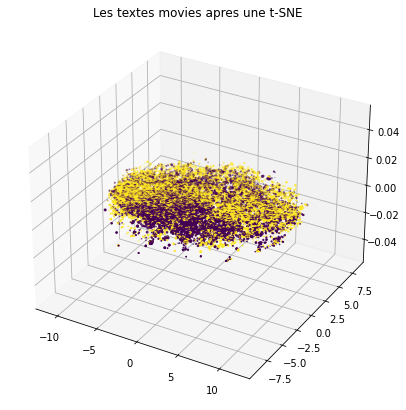

In [13]:
tsne = TSNE(n_components=3, init='pca',n_iter=500, verbose=0)

repre_2D = tsne.fit_transform(text_train_vectorized)

fig = plt.figure(figsize=(20,7))
fig.add_subplot(projection='3d')

plt.title("Les textes movies apres une t-SNE")
plt.scatter(repre_2D[:,0],repre_2D[:,1],repre_2D[:,2],c=labels_train)
plt.show()

In [9]:
np.random.seed(42)
nb_classes = len(np.unique(labels_train))
n_samples = text_train_vectorized.shape[0]


neuro_i_1 = 100
neuro_o_1 = 50
neuro_i_2 = 50
neuro_o_2 = 20
neuro_i_3 = 20
neuro_o_3 = 1
facteur_norma = 0.4
plage_biais = (0,1)
batch_size = 50
epochs = 50


facteur_norma = 0.8
lineaire_1 = ModuleLineaire(neuro_i_1 ,neuro_o_1 ,plage_biais,facteur_norma)
lineaire_2 = ModuleLineaire(neuro_i_2 ,neuro_o_2 ,plage_biais,facteur_norma)
lineaire_3 = ModuleLineaire(neuro_i_3 ,neuro_o_3 ,plage_biais,facteur_norma)

TanH = ModuleTanH()
sigmoide = ModuleSigmoide()
mseloss = MSELoss()
CE = CrossEntropieLoss(nb_classes)
softmax = SoftMax()


network_layers = [lineaire_1,TanH,lineaire_2,sigmoide,lineaire_3,sigmoide]
network = Sequentiel(network_layers)

opti = Optim(network,mseloss,1e-3)
opti.SGD(text_train_vectorized,labels_train,batch_size,epochs)

print("Accuracy sur le train : ",opti.getNetwork().accuracy(text_train_vectorized,labels_train))
print("Accuracy sur le test : ",opti.getNetwork().accuracy(text_test_vectorized,labels_test))


100%|███████████████████████████████████████████| 50/50 [00:36<00:00,  1.37it/s]


Accuracy sur le train :  0.8226
Accuracy sur le test :  0.8166
